## Voice Authentication and Face Recognition

In [ ]:
!apt install libasound2-dev portaudio19-dev libportaudio2 libportaudiocpp0 ffmpeg

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libasound2-dev is already the newest version (1.2.6.1-1ubuntu1).
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
Suggested packages:
  portaudio19-doc
The following NEW packages will be installed:
  libportaudio2 libportaudiocpp0 portaudio19-dev
0 upgraded, 3 newly installed, 0 to remove and 15 not upgraded.
Need to get 188 kB of archives.
After this operation, 927 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libportaudio2 amd64 19.6.0-1.1 [65.3 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libportaudiocpp0 amd64 19.6.0-1.1 [16.1 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 portaudio19-dev amd64 19.6.0-1.1 [106 kB]
Fetched 188 kB in 1s (201 kB/s)
Selecting previously unselected package libportaudio2:amd64.
(Reading database ... 120899 files and directories currently installed.)
Pre

In [ ]:
!pip install PyAudio

  Using cached PyAudio-0.2.14.tar.gz (47 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for PyAudio: filename=PyAudio-0.2.14-cp310-cp310-linux_x86_64.whl size=63858 sha256=804e0a30c1775a3a5029891a1658bf002d45be03bf96137fe879becd2b188f42
  Stored in directory: /root/.cache/pip/wheels/d6/21/f4/0b51d41ba79e51b16295cbb096ec49f334792814d545b508c5
Successfully built PyAudio


In [ ]:
!pip install python_speech_features

  Preparing metadata (setup.py) ... done
  Created wheel for python_speech_features: filename=python_speech_features-0.6-py3-none-any.whl size=5869 sha256=48e741a4554b899e20cfc3090d2526da3a936d90851ba583b005e26ca4510b68
  Stored in directory: /root/.cache/pip/wheels/5a/9e/68/30bad9462b3926c29e315df16b562216d12bdc215f4d240294
Successfully built python_speech_features


In [ ]:
import tensorflow as tf
import numpy as np
import os
import glob
import pickle
import cv2
import time
from numpy import genfromtxt

from keras import backend as K
from keras.models import load_model
K.set_image_data_format('channels_first')


import pyaudio
from IPython.display import Audio, display, clear_output
import wave
from scipy.io.wavfile import read
from sklearn import mixture
import warnings
warnings.filterwarnings("ignore")

from sklearn import preprocessing
import python_speech_features as mfcc

## Facial Encodings

The model provides output as 128 dim encoding vector for the input image.

In [ ]:
#provides 128 dim embeddings for face
def img_to_encoding(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    #converting img format to channel first
    img = np.around(np.transpose(img, (2,0,1))/255.0, decimals=12)

    x_train = np.array([img])

    #facial embedding from trained model
    embedding = model.predict_on_batch(x_train)
    return embedding

## Triplet Loss

Two encodings are compared and if they are similar then two images are of the same person otherwise they are different.

In [ ]:
def triplet_loss(y_true, y_pred, alpha = 0.2):
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]

    # triplet loss formula
    pos_dist = tf.reduce_sum( tf.square(tf.subtract(y_pred[0], y_pred[1])) )
    neg_dist = tf.reduce_sum( tf.square(tf.subtract(y_pred[0], y_pred[2])) )
    basic_loss = pos_dist - neg_dist + alpha

    loss = tf.maximum(basic_loss, 0.0)

    return loss

# load the model
model = load_model('yolov8_model/model.h5', custom_objects={'triplet_loss': triplet_loss})

OSError: ignored

## Audio processing

In [ ]:
#Calculate and returns the delta of given feature vector matrix
def calculate_delta(array):
    rows,cols = array.shape
    deltas = np.zeros((rows,20))
    N = 2
    for i in range(rows):
        index = []
        j = 1
        while j <= N:
            if i-j < 0:
                first = 0
            else:
                first = i-j
            if i+j > rows -1:
                second = rows -1
            else:
                second = i+j
            index.append((second,first))
            j+=1
        deltas[i] = ( array[index[0][0]]-array[index[0][1]] + (2 * (array[index[1][0]]-array[index[1][1]])) ) / 10
    return deltas

#convert audio to mfcc features
def extract_features(audio,rate):
    mfcc_feat = mfcc.mfcc(audio,rate, 0.025, 0.01,20,appendEnergy = True, nfft=1103)
    mfcc_feat = preprocessing.scale(mfcc_feat)
    delta = calculate_delta(mfcc_feat)

    #combining both mfcc features and delta
    combined = np.hstack((mfcc_feat,delta))
    return combined

## Add a New User

In [ ]:
def add_user():

    name = input("Enter Name:")
     # check for existing database
    if os.path.exists('./face_database/embeddings.pickle'):
        with open('./face_database/embeddings.pickle', 'rb') as database:
            db = pickle.load(database)

            if name in db or name == 'unknown':
                print("Name Already Exists! Try Another Name...")
                return
    else:
        #if database not exists than creating new database
        db = {}

    cap = cv2.VideoCapture(0)
    cap.set(3, 640)
    cap.set(4, 480)

    #detecting only frontal face using haarcascade
    face_cascade = cv2.CascadeClassifier('./haarcascades/haarcascade_frontalface_default.xml')

    i = 3
    face_found = False

    while True:
        _, frame = cap.read()
        frame = cv2.flip(frame, 1, 0)

        #time.sleep(1.0)
        cv2.putText(frame, 'Keep Your Face infront of Camera', (100, 200),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)

        cv2.putText(frame, 'Starting', (260, 270), cv2.FONT_HERSHEY_SIMPLEX,
                    0.8, (255, 255, 255), 2)

        cv2.putText(frame, str(i), (290, 330), cv2.FONT_HERSHEY_SIMPLEX,
                    1.3, (255, 255, 255), 3)

        i-=1

        cv2.imshow('frame', frame)
        cv2.waitKey(1000)

        if i < 0:
            break

    start_time = time.time()
    img_path = './saved_image/1.jpg'

    ## Face recognition
    while True:
        curr_time = time.time()

        _, frame = cap.read()
        frame = cv2.flip(frame, 1, 0)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        face = face_cascade.detectMultiScale(gray, 1.3, 5)

        if len(face) == 1:
            for(x, y, w, h) in face:
                roi = frame[y-10:y+h+10, x-10:x+w+10]

                fh, fw = roi.shape[:2]

                #make sure the face roi is of required height and width
                if fh < 20 and fw < 20:
                    continue

                face_found = True
                #cv2.imwrite(img_path, roi)

                cv2.rectangle(frame, (x-10,y-10), (x+w+10, y+h+10), (255, 200, 200), 2)


        if curr_time - start_time >= 3:
            break

        cv2.imshow('frame', frame)
        cv2.waitKey(1)

    cap.release()
    cv2.destroyAllWindows()


    if face_found:
        img = cv2.resize(roi, (96, 96))

        db[name] = img_to_encoding(img)

        with open('./face_database/embeddings.pickle', "wb") as database:
            pickle.dump(db, database, protocol=pickle.HIGHEST_PROTOCOL)

    elif len(face) > 1:
        print("More than one faces found. Try again...")
        return

    else:
        print('There was no face found in the frame. Try again...')
        return

    clear_output(wait=True)

    #Voice authentication
    FORMAT = pyaudio.paInt16
    CHANNELS = 2
    RATE = 44100
    CHUNK = 1024
    RECORD_SECONDS = 3

    source = "./voice_database/" + name


    os.mkdir(source)

    for i in range(3):
        audio = pyaudio.PyAudio()

        if i == 0:
            j = 3
            while j>=0:
                time.sleep(1.0)
                print("Speak your name in {} seconds".format(j))
                clear_output(wait=True)

                j-=1

        elif i ==1:
            print("Speak your name one more time")
            time.sleep(0.5)

        else:
            print("Speak your name one last time")
            time.sleep(0.5)

        # start Recording
        stream = audio.open(format=FORMAT, channels=CHANNELS,
                    rate=RATE, input=True,
                    frames_per_buffer=CHUNK)

        print("recording...")
        frames = []

        for _ in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
            data = stream.read(CHUNK)
            frames.append(data)

        # stop Recording
        stream.stop_stream()
        stream.close()
        audio.terminate()

        # saving wav file of speaker
        waveFile = wave.open(source + '/' + str((i+1)) + '.wav', 'wb')
        waveFile.setnchannels(CHANNELS)
        waveFile.setsampwidth(audio.get_sample_size(FORMAT))
        waveFile.setframerate(RATE)
        waveFile.writeframes(b''.join(frames))
        waveFile.close()
        print("Done")

    dest =  "./gmm_models/"
    count = 1

    for path in os.listdir(source):
        path = os.path.join(source, path)

        features = np.array([])

        # reading audio files of speaker
        (sr, audio) = read(path)

        # extract 40 dimensional MFCC & delta MFCC features
        vector   = extract_features(audio,sr)

        if features.size == 0:
            features = vector
        else:
            features = np.vstack((features, vector))

        # when features of 3 files of speaker are concatenated, then do model training
        if count == 3:
            gmm = GMM(n_components = 16, n_iter = 200, covariance_type='diag',n_init = 3)
            gmm.fit(features)

            # saving the trained gaussian model
            pickle.dump(gmm, open(dest + name + '.gmm', 'wb'))
            print(name + ' added successfully')

            features = np.asarray(())
            count = 0
        count = count + 1

if __name__ == '__main__':
    add_user()

recording...
Done
Speak your name one more time
recording...
Done
Speak your name one last time
recording...
Done
Julien added successfully


## Delete User

In [ ]:
# deletes a registered user from database
def delete_user():
    name = input("Enter name of the user:")

    with open("./face_database/embeddings.pickle", "rb") as database:
        db = pickle.load(database)
        user = db.pop(name, None)

        if user is not None:
            print('User ' + name + ' deleted successfully')
            # save the database
            with open('face_database/embeddings.pickle', 'wb') as database:
                    pickle.dump(db, database, protocol=pickle.HIGHEST_PROTOCOL)

            # remove the speaker wav files and gmm model
            [os.remove(path) for path in glob.glob('./voice_database/' + name + '/*')]
            os.removedirs('./voice_database/' + name)
            os.remove('./gmm_models/' + name + '.gmm')

        else:
            print('No such user !!')

delete_user()

Enter name of the user:test
No such user !!


## Voice Authentication and Face Recognition

In [ ]:
def recognize():
    # Voice Authentication
    FORMAT = pyaudio.paInt16
    CHANNELS = 2
    RATE = 44100
    CHUNK = 1024
    RECORD_SECONDS = 3
    FILENAME = "./test.wav"

    audio = pyaudio.PyAudio()

    # start Recording
    stream = audio.open(format=FORMAT, channels=CHANNELS,
                    rate=RATE, input=True,
                    frames_per_buffer=CHUNK)

    print("recording...")
    frames = []

    for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
        data = stream.read(CHUNK)
        frames.append(data)
    print("finished recording")


    # stop Recording
    stream.stop_stream()
    stream.close()
    audio.terminate()

    # saving wav file
    waveFile = wave.open(FILENAME, 'wb')
    waveFile.setnchannels(CHANNELS)
    waveFile.setsampwidth(audio.get_sample_size(FORMAT))
    waveFile.setframerate(RATE)
    waveFile.writeframes(b''.join(frames))
    waveFile.close()

    modelpath = "./gmm_models/"

    gmm_files = [os.path.join(modelpath,fname) for fname in
                os.listdir(modelpath) if fname.endswith('.gmm')]

    models    = [pickle.load(open(fname,'rb')) for fname in gmm_files]

    speakers   = [fname.split("/")[-1].split(".gmm")[0] for fname
                in gmm_files]

    if len(models) == 0:
        print("No Users in the Database!")
        return

    #read test file
    sr,audio = read(FILENAME)

    # extract mfcc features
    vector = extract_features(audio,sr)
    log_likelihood = np.zeros(len(models))

    #checking with each model one by one
    for i in range(len(models)):
        gmm = models[i]
        scores = np.array(gmm.score(vector))
        log_likelihood[i] = scores.sum()

    pred = np.argmax(log_likelihood)
    identity = speakers[pred]

    # if voice not recognized than terminate the process
    if identity == 'unknown':
            print("Not Recognized! Try again...")
            return

    print( "Recognized as - ", identity)

    # face recognition
    print("Keep Your face infront of the camera")
    cap = cv2.VideoCapture(0)
    cap.set(3, 640)
    cap.set(4, 480)

    cascade = cv2.CascadeClassifier('./haarcascades/haarcascade_frontalface_default.xml')

    #loading the database
    database = pickle.load(open('face_database/embeddings.pickle', "rb"))

    time.sleep(1.0)

    start_time = time.time()

    while True:
        curr_time = time.time()

        _, frame = cap.read()
        frame = cv2.flip(frame, 1, 0)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        face = cascade.detectMultiScale(gray, 1.3, 5)

        name = 'unknown'


        if len(face) == 1:

            for (x, y, w, h) in face:
                roi = frame[y-10:y+h+10, x-10:x+w+10]

                fh, fw = roi.shape[:2]
                min_dist = 100

                #make sure the face is of required height and width
                if fh < 20 and fh < 20:
                    continue


                #resizing image as required by the model
                img = cv2.resize(roi, (96, 96))

                #128 d encodings from pre-trained model
                encoding = img_to_encoding(img)

                # loop over all the recorded encodings in database
                for knownName in database:
                    # find the similarity between the input encoding and
                    #recorded encodings in database using L2 norm
                    dist = np.linalg.norm(np.subtract(database[knownName], encoding) )

                    # check if minimum distance or not
                    if dist < min_dist:
                        min_dist = dist
                        name = knownName

            # if min dist is less then threshold value and
            #both face and voice matched than unlock the door
            if min_dist < 0.4 and name == identity:
                print ("Door Unlocked! Welcome " + str(name))
                break

        #open the cam for 3 seconds
        if curr_time - start_time >= 3:
            break

        cv2.waitKey(1)
        cv2.imshow('frame', frame)

    cap.release()
    cv2.destroyAllWindows()

    if len(face) == 0:
        print('There was no face found in the frame. Try again...')

    elif len(face) > 1:
        print("More than one faces found. Try again...")

    elif min_dist > 0.5 or name != identity:
        print("Not Recognized! Try again...")


if __name__ == '__main__':
    recognize()

recording...
finished recording
Not Recognized! Try again...


## Another version of recognizing user will keep runnning until KeyboardInterrupt by the user

In [ ]:
def recognize():
    # Voice Authentication
    FORMAT = pyaudio.paInt16
    CHANNELS = 2
    RATE = 44100
    CHUNK = 1024
    RECORD_SECONDS = 3
    FILENAME = "./test.wav"
    try:
        while True:
            audio = pyaudio.PyAudio()

            # start Recording
            stream = audio.open(format=FORMAT, channels=CHANNELS,
                            rate=RATE, input=True,
                            frames_per_buffer=CHUNK)

            print("recording...")
            frames = []

            for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
                data = stream.read(CHUNK)
                frames.append(data)
            print("finished recording")


            # stop Recording
            stream.stop_stream()
            stream.close()
            audio.terminate()

            # saving wav file
            waveFile = wave.open(FILENAME, 'wb')
            waveFile.setnchannels(CHANNELS)
            waveFile.setsampwidth(audio.get_sample_size(FORMAT))
            waveFile.setframerate(RATE)
            waveFile.writeframes(b''.join(frames))
            waveFile.close()

            modelpath = "./gmm_models/"

            gmm_files = [os.path.join(modelpath,fname) for fname in
                        os.listdir(modelpath) if fname.endswith('.gmm')]

            models    = [pickle.load(open(fname,'rb')) for fname in gmm_files]

            speakers   = [fname.split("/")[-1].split(".gmm")[0] for fname
                        in gmm_files]

            if len(models) == 0:
                print("No Users Authorized!")
                break

            #read test file
            sr,audio = read(FILENAME)

            # extract mfcc features
            vector = extract_features(audio,sr)
            log_likelihood = np.zeros(len(models))

            #checking with each model one by one
            for i in range(len(models)):
                gmm = models[i]
                scores = np.array(gmm.score(vector))
                log_likelihood[i] = scores.sum()

            pred = np.argmax(log_likelihood)
            identity = speakers[pred]

            # if voice not recognized than terminate the process
            if identity == 'unknown':
                    print("Not Recognized! Try again...")
                    continue

            print( "Recognized as - ", identity)

             # face recognition
            print("Keep Your face infront of the camera")
            cap = cv2.VideoCapture(0)
            cap.set(3, 640)
            cap.set(4, 480)
            img_path = './saved_image/2.jpg'

            cascade = cv2.CascadeClassifier(
                        './haarcascades/haarcascade_frontalface_default.xml')

            #loading the database
            database = pickle.load(open('face_database/embeddings.pickle', "rb"))

            time.sleep(1.0)

            start_time = time.time()

            while True:
                curr_time = time.time()

                _, frame = cap.read()
                frame = cv2.flip(frame, 1, 0)
                gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

                face = cascade.detectMultiScale(gray, 1.3, 5)

                name = 'unknown'

                if len(face) == 1:

                    for (x, y, w, h) in face:
                        roi = frame[y-10:y+h+10, x-10:x+w+10]

                        fh, fw = roi.shape[:2]
                        min_dist = 100

                        #make sure the face is of required height and width
                        if fh < 20 and fh < 20:
                            continue

                        #resizing image as required by the model
                        img = cv2.resize(roi, (96, 96))

                        #128 d encodings from pre-trained model
                        encoding = img_to_encoding(img)

                        # loop over all the recorded encodings in database
                        for knownName in database:
                            # find the similarity between the input encodings
                            # and recorded encodings in database using L2 norm
                            dist = np.linalg.norm(np.subtract(database[knownName], encoding) )

                            # check if minimum distance or not
                            if dist < min_dist:
                                min_dist = dist
                                name = knownName

                    # if min dist is less then threshold value
                    # and both face and voice matched than unlock the door
                    if min_dist < 0.4 and name == identity:
                        print ("Door Unlocked! Welcome " + str(name))
                        break

                #open the cam for 3 seconds
                if curr_time - start_time >= 3:
                    break

                cv2.waitKey(1)
                cv2.imshow('frame', frame)

            cap.release()
            cv2.destroyAllWindows()

            if len(face) == 0:
                print('There was no face found in the frame. Try again...')
                continue

            elif len(face) > 1:
                print("More than one faces found. Try again...")
                continue

            elif min_dist > 0.4 or name != identity:
                print("Not Recognized! Try again...")
                continue

    except KeyboardInterrupt:
        print("Stopped")
        pass

if __name__ == '__main__':
    recognize()

recording...
finished recording
Not Recognized! Try again...
recording...
finished recording
Not Recognized! Try again...
recording...
finished recording
Not Recognized! Try again...
recording...
finished recording
Not Recognized! Try again...
recording...
finished recording
Not Recognized! Try again...
recording...
finished recording
Not Recognized! Try again...
recording...
Stopped


In [ ]:
from sklearn.mixture import

In [ ]:
import sklearn
sklearn.__version__

'0.19.2'

## Register users from database

There are 7 users with each 100 samples.
Similar to how the registering is done in previous section.

* 3 sample audio of 3 seconds for training
* 1 face picture for training

* rest is for testing

In [ ]:
user_names = ["man_italian", "man_polish", "woman_russian", "woman_french", "woman_japanese", "woman_american"]

# First delete the user if already saved
if os.path.exists('./face_database/embeddings.pickle'):
    with open("./face_database/embeddings.pickle", "rb") as database:
        db = pickle.load(database)
        for name in user_names:
            user = db.pop(name, None)

            if user is not None:
                # remove the speaker wav files and gmm model
                #[os.remove(path) for path in glob.glob('./voice_database/' + name + '/*')]
                #os.removedirs('./voice_database/' + name)
                os.remove('./gmm_models/' + name + '.gmm')

    # save the database
    with open('face_database/embeddings.pickle', 'wb') as database:
            pickle.dump(db, database, protocol=pickle.HIGHEST_PROTOCOL)

# Now add users
for i, name in enumerate(user_names):
    if os.path.exists('./face_database/embeddings.pickle'):
        with open('./face_database/embeddings.pickle', 'rb') as database:
            db = pickle.load(database)

            if name in db or name == 'unknown':
                print("Name Already Exists! Try Another Name...")
                continue
    else:
        #if database not exists than creating new database
        db = {}

    #detecting only frontal face using haarcascade
    face_cascade = cv2.CascadeClassifier('./haarcascades/haarcascade_frontalface_default.xml')

    img_path = f'./dataset/face/face{i}_1.jpg'
    print(img_path)
    frame = cv2.imread(img_path)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    face = face_cascade.detectMultiScale(gray, 1.3, 5)

    if len(face) != 1:
        print("Face not detected!")

    x, y, w, h = face[0]
    roi = frame[y-10:y+h+10, x-10:x+w+10]
    img = cv2.resize(roi, (96, 96))
    db[name] = img_to_encoding(img)

    with open('./face_database/embeddings.pickle', "wb") as database:
        pickle.dump(db, database, protocol=pickle.HIGHEST_PROTOCOL)

    #Voice authentication
    FORMAT = pyaudio.paInt16
    CHANNELS = 2
    RATE = 44100
    CHUNK = 1024
    RECORD_SECONDS = 3

    dest =  "./gmm_models/"
    count = 1

    audio_files = [
        f'./dataset/voice/voice{i}_0.wav',
        f'./dataset/voice/voice{i}_1.wav',
        f'./dataset/voice/voice{i}_2.wav',
    ]
    features = np.array([])
    for j, path in enumerate(audio_files):

        # reading audio files of speaker
        (sr, audio) = read(path)

        # extract 40 dimensional MFCC & delta MFCC features
        vector   = extract_features(audio,sr)

        if features.size == 0:
            features = vector
        else:
            features = np.vstack((features, vector))

    gmm = GMM(n_components = 16, n_iter = 200, covariance_type='diag',n_init = 3)
    gmm.fit(features)

    # saving the trained gaussian model
    pickle.dump(gmm, open(dest + name + '.gmm', 'wb'))
    print(name + ' added successfully')

./dataset/face/face0_1.jpg
man_italian added successfully
./dataset/face/face1_1.jpg
man_polish added successfully
./dataset/face/face2_1.jpg
woman_russian added successfully
./dataset/face/face3_1.jpg
woman_french added successfully
./dataset/face/face4_1.jpg
woman_japanese added successfully
./dataset/face/face5_1.jpg
woman_american added successfully


## Matplotlib

For plotting the ROC curves

In [ ]:
!pip install matplotlib

## Face recognition

The face classifier returns a distance (the minimum being the most probable),
to convert this into probabilities, the softmax of the negative distance is used.

If no face is detected, the probabilities are assumed to be all equal for all classes.



EER class 0 vs rest: 0.06794990723562357
EER class 1 vs rest: 0.13265306122448986
EER class 2 vs rest: 0.46530612244772834
EER class 3 vs rest: 0.030612244897959256
EER class 4 vs rest: 0.2200086383759853
EER class 5 vs rest: 0.2199546485261278


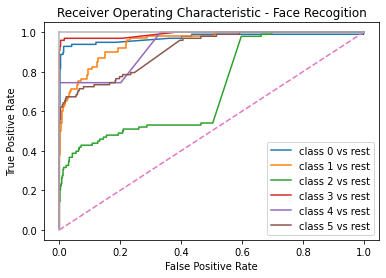

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from scipy.optimize import brentq
from scipy.interpolate import interp1d

#loading the database
database = pickle.load(open('face_database/embeddings.pickle', "rb"))

time.sleep(1.0)


# num samples per class
num_samples = 100

faces = [name for name in database]
y_score = np.zeros(((num_samples-2)*len(user_names), len(user_names)))
y_true = np.zeros(((num_samples-2)*len(user_names)))

idx = 0
for i, name in enumerate(user_names):
    good = 0
    bad = 0
    for j in range(2, num_samples):
        y_true[idx] = i

        img_path = f'./dataset/face/face{i}_{j}.jpg'
        frame = cv2.imread(img_path)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        face = face_cascade.detectMultiScale(gray, 1.3, 5)
        if len(face) == 1:
            for (x, y, w, h) in face:
                roi = frame[y-10:y+h+10, x-10:x+w+10]

                fh, fw = roi.shape[:2]
                min_dist = 100

                #make sure the face is of required height and width
                if fh < 20 and fh < 20:
                    continue


                #resizing image as required by the model
                img = cv2.resize(roi, (96, 96))

                #128 d encodings from pre-trained model
                encoding = img_to_encoding(img)

                # loop over all the recorded encodings in database
                dists = np.zeros(len(user_names))
                for k, knownName in enumerate(user_names):
                    # find the similarity between the input encoding and
                    #recorded encodings in database using L2 norm
                    dist = np.linalg.norm(np.subtract(database[knownName], encoding) )
                    dists[k] = dist

                # Compute softmax
                dists = np.exp(-dists)/np.sum(np.exp(-dists))
                y_score[idx,:] = dists
        else:
            y_score[idx,:] = np.ones(len(user_names))/len(user_names)
        idx += 1
curves = []

# Convert to one hot
y_true = label_binarize(y_true, classes=list(range(len(user_names))))
for i in range(len(user_names)):
    curves.append(roc_curve(y_true[:,i], y_score[:,i]))

# Plot curves
plt.title('Receiver Operating Characteristic - Face Recogition')
legends = []

for i in range(len(user_names)):
    fpr, tpr, _ = curves[i]
    plt.plot(fpr, tpr)
    legends.append(f'class {i} vs rest')
    eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
    print(f'EER class {i} vs rest: {eer}')
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(legends)
plt.show()

## Voice recognition

[-15259.54674077 -17043.92531673 -16311.34245072 -15541.7813214
 -20573.71895757 -15264.39467387]
EER class 0 vs rest: 0.2499999999998785
EER class 1 vs rest: 0.04166666666715286
EER class 2 vs rest: 0.020833333333403533
EER class 3 vs rest: 0.11458333333200521
EER class 4 vs rest: 0.14391025641025648
EER class 5 vs rest: 0.27083333333333337


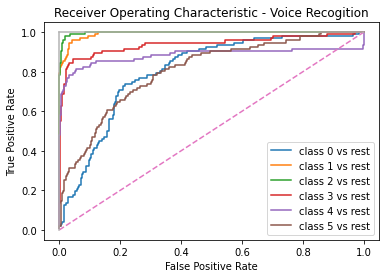

In [ ]:
modelpath = "./gmm_models/"

gmm_files = [os.path.join(modelpath,name + ".gmm") for name in
            user_names]

models    = [pickle.load(open(fname,'rb')) for fname in gmm_files]

speakers   = [fname.split("/")[-1].split(".gmm")[0] for fname
            in gmm_files]

if len(models) == 0:
    print("No Users in the Database!")

assert(len(models) == len(user_names), "only dataset must be in database")

# num samples per class
num_samples = 100

y_score = np.zeros(((num_samples-4)*len(user_names), len(user_names)))
y_true = np.zeros(((num_samples-4)*len(user_names)))

idx = 0

for i, name in enumerate(user_names):
    for j in range(4, num_samples):
        #read test file
        sr,audio = read(f'dataset/voice/voice{i}_{j}.wav')

        # extract mfcc features
        vector = extract_features(audio,sr)
        log_likelihood = np.zeros(len(models))

        #checking with each model one by one
        for k in range(len(models)):
            gmm = models[k]
            scores = np.array(gmm.score(vector))
            log_likelihood[k] = scores.sum()

        # Compute softmax
        y_score[idx,:] = log_likelihood
        y_true[idx] = i

        idx += 1

curves = []

# Convert to one hot
y_true = label_binarize(y_true, classes=list(range(len(user_names))))
for i in range(len(user_names)):
    curves.append(roc_curve(y_true[:,i], y_score[:,i]))

# Plot curves
plt.title('Receiver Operating Characteristic - Voice Recogition')
legends = []

for i in range(len(user_names)):
    fpr, tpr, _ = curves[i]
    plt.plot(fpr, tpr)
    legends.append(f'class {i} vs rest')
    eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
    print(f'EER class {i} vs rest: {eer}')

plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(legends)
plt.show()

## Fusion data

Compute the EER of the fusion of those two classifiers.

* Voice recognition gives as an output a log-likelihood (GMM)
* Face recognition gives a distance in a feature space

#### Convert log likelihood to probabilities

This does not really make sense but we can transform the log-likelihood
to a discrete probability with:

$P(x|\theta_1) = e^{l(x|\theta_1)}$

The probability is further normaized with:

$P(x|\theta_1) = \frac{e^{l(x|\theta_1)}}{\sum_i e^{l(x|\theta_i)}}$

The results are usually too small, so the maximum is factored out.

$P(x|\theta_1) = \frac{e^{l_{max}} \cdot e^{l(x|\theta_1) - l_{max}}}{e^{l_{max}} \cdot \sum_i e^{l(x|\theta_i) - l_{max}}} = \frac{e^{l(x|\theta_1) - l_{max}}}{\sum_i e^{l(x|\theta_i) - l_{max}}}$

#### Convert distance to probabilities

There are multiple ways to convert, here we use the softmax
of the negative distance. Simple averaging could also be used.

$P(x_i) = \frac{e^{-d_i}}{\sum_j e^{-d_j}}$

#### Combine probabilities

Finally, the probabilities are combined with a weighted average.

The GMM (audio recognition) tend to give very extreme probabilities,
more weight is put on face recognition to counteract this effect.


EER class 0 vs rest: 0.01041666666697005
EER class 1 vs rest: 0.01041666666705905
EER class 2 vs rest: 0.0
EER class 3 vs rest: 0.0229166666667878
EER class 4 vs rest: 0.02083333333333341
EER class 5 vs rest: 0.006250000000944302


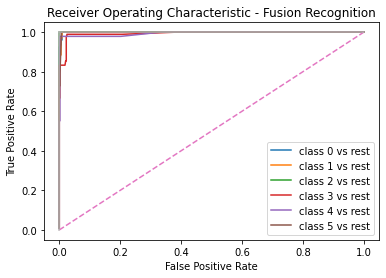

In [ ]:
modelpath = "./gmm_models/"

gmm_files = [os.path.join(modelpath,name + ".gmm") for name in
            user_names]

models    = [pickle.load(open(fname,'rb')) for fname in gmm_files]

speakers   = [fname.split("/")[-1].split(".gmm")[0] for fname
            in gmm_files]

if len(models) == 0:
    print("No Users in the Database!")

assert(len(models) == len(user_names), "only dataset must be in database")

# num samples per class
num_samples = 100

y_score = np.zeros(((num_samples-4)*len(user_names), len(user_names)))
y_true = np.zeros(((num_samples-4)*len(user_names)))

idx = 0

good = 0
bad = 0

for i, name in enumerate(user_names):
    for j in range(4, num_samples):
        #read test file
        sr,audio = read(f'dataset/voice/voice{i}_{j}.wav')

        # extract mfcc features
        vector = extract_features(audio,sr)
        log_likelihood = np.zeros(len(models))

        #checking with each model one by one
        for k in range(len(models)):
            gmm = models[k]
            scores = np.array(gmm.score(vector))
            log_likelihood[k] = scores.sum()

        #convert log likelihood to probabilities
        lmax = np.max(log_likelihood)
        p1 = np.exp(log_likelihood-lmax)/np.sum(np.exp(log_likelihood-lmax))

        img_path = f'./dataset/face/face{i}_{j}.jpg'
        frame = cv2.imread(img_path)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        face = face_cascade.detectMultiScale(gray, 1.3, 5)
        if len(face) == 1:
            for (x, y, w, h) in face:
                roi = frame[y-10:y+h+10, x-10:x+w+10]

                fh, fw = roi.shape[:2]
                min_dist = 100

                #make sure the face is of required height and width
                if fh < 20 and fh < 20:
                    continue


                #resizing image as required by the model
                img = cv2.resize(roi, (96, 96))

                #128 d encodings from pre-trained model
                encoding = img_to_encoding(img)

                # loop over all the recorded encodings in database
                dists = np.zeros(len(user_names))
                for k, knownName in enumerate(user_names):
                    # find the similarity between the input encoding and
                    #recorded encodings in database using L2 norm
                    dist = np.linalg.norm(np.subtract(database[knownName], encoding) )
                    dists[k] = dist

                # Compute softmax
                p2 = np.exp(-dists)/np.sum(np.exp(-dists))
        else:
            p2 = np.ones(len(user_names))/len(user_names)

        y_score[idx,:] = (p1+p2)/2
        y_true[idx] = i
        idx += 1

curves = []

# Convert to one hot
y_true = label_binarize(y_true, classes=list(range(len(user_names))))
for i in range(len(user_names)):
    curves.append(roc_curve(y_true[:,i], y_score[:,i]))

# Plot curves
plt.title('Receiver Operating Characteristic - Fusion Recognition')
legends = []

for i in range(len(user_names)):
    fpr, tpr, _ = curves[i]
    plt.plot(fpr, tpr)
    legends.append(f'class {i} vs rest')
    eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
    print(f'EER class {i} vs rest: {eer}')

plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(legends)
plt.show()